In [2]:
import numpy as np
import sqlite3 as sq
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from collections import Counter
import pyasn
import requests
from mpl_toolkits.basemap import Basemap
import time
import json
import importlib
import fluctuations
import tldextract
importlib.reload(fluctuations)

from colors import Colors

%matplotlib inline

In [3]:
connection = sq.connect("./merged-result.db")
connection.row_factory = sq.Row

## Deployment Fluctuation Week over Week

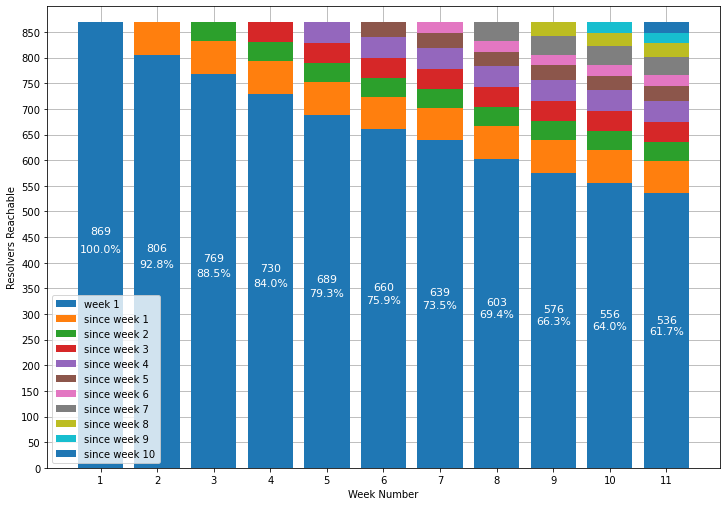

In [255]:
weeks = fluctuations.getWeeklyServers()

results = [{ "week 1": len(weeks[0]) }]
sets = [weeks[0]]
temp = {}

for i in range(1, len(weeks)):
    result = {}
    notInWeek = sets[i - 1] - weeks[i]
    sets.append(sets[i - 1] - notInWeek)
    result["week {}".format(1)] = len(sets[i - 1]) - len(notInWeek)
    temp["since week {}".format(str(i))] = len(notInWeek)
    result = { **result, **temp }
        
    results.append(result)

results_pd = pd.DataFrame(results).fillna(0)

fig, ax = plt.subplots(figsize = (10, 7))
labels = [i for i in range(1, results_pd.keys().size + 1)]

def plot(week, bottom = None):
    return ax.bar(labels, results_pd[week], label = week, bottom = bottom)

pd_keys = results_pd.keys()
bar = plot("week 1")
total = results_pd["week 1"]
total_percentage = results_pd["week 1"] / results_pd["week 1"][0]

for idx, rect in enumerate(bar):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 0.52*height,
                total[idx],
                ha='center', va='bottom', color = "white", fontsize = 11)
        ax.text(rect.get_x() + rect.get_width()/2., 0.48*height,
                "{:.1%}".format(total_percentage[idx]),
                ha='center', va='bottom', color = "white", fontsize = 11)

start = results_pd["week 1"]
for i in range(1, len(pd_keys)):
    plot(pd_keys[i], bottom = start)
    start = start + results_pd[pd_keys[i]]

ax.legend()
plt.ylim([0, 900])
plt.tight_layout()
ax.set_xlabel("Week Number")
ax.set_ylabel("Resolvers Reachable")
ax.set_xticks(labels)
ax.set_axisbelow(True)
plt.grid()
plt.yticks([i for i in range(0, 900, 50)])


plt.savefig("figures/resolver_reachable_from_week.pdf", bbox_inches='tight')
plt.show()

## Port Weekly

In [107]:
port_per_week = pd.DataFrame(fluctuations.getWeeklyByPort()).fillna(0)

In [108]:
for column in port_per_week.columns:
    port_per_week[column + "%"] = (port_per_week[column] / port_per_week.sum(axis = 1)) * 100

In [148]:
port_per_week

,784,8853,784+8853,853,784%,8853%,784+8853%,853%
0,686,170,13,0.0,78.941312,17.933600,1.345930,0.000000
1,692,168,13,0.0,79.266896,17.642113,1.340332,0.000000
2,706,169,14,0.0,79.415073,17.451195,1.420071,0.000000
3,690,171,14,0.0,78.857143,17.927213,1.440649,0.000000
4,684,194,14,0.0,76.681614,20.027220,1.415988,0.000000
5,679,194,14,2.0,76.377953,20.095756,1.420637,0.202656
6,680,195,13,1.0,76.490439,20.196989,1.318877,0.101316
7,684,192,14,1.0,76.767677,19.839472,1.417568,0.101110
8,695,213,13,1.0,75.379610,21.355961,1.276092,0.098038
9,703,213,14,1.0,75.510204,21.162230,1.362302,0.097178


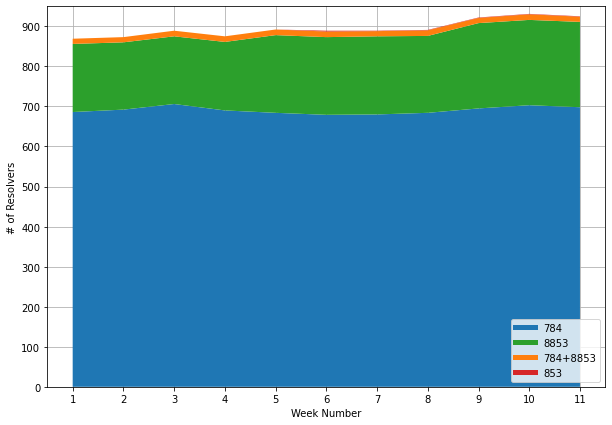

In [83]:
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(1,1,1)

plt.plot([], [], color="tab:blue", label="784", linewidth=5)
plt.plot([], [], color="tab:green", label="8853", linewidth=5)
plt.plot([], [], color="tab:orange", label="784+8853", linewidth=5)
plt.plot([], [], color="tab:red", label="853", linewidth=5)

groups = [port_per_week[group].tolist() for group in port_per_week]

labels = [i for i in range(1, len(port_per_week.index) + 1)]

plt.stackplot(labels, *groups, colors=["tab:blue", "tab:green", "tab:orange", "tab:red"])
plt.xlabel("Week Number")
plt.ylabel("# of Resolvers")
plt.xticks(labels)
ax.set_axisbelow(True)
plt.grid()
plt.yticks([i for i in range(0, 1000, 100)])
plt.ylim([0, 950])
plt.xlim([0.5, 11.5])


plt.legend(loc = "lower right")
plt.savefig("figures/total_doq_resolver_per_week.pdf", bbox_inches='tight')
plt.show()

### Common Names

In [277]:
def buildExtractedDomain(extracted):
    result = ""
    if extracted.subdomain != "" and extracted.subdomain != "*":
        result += extracted.subdomain + "."
    if extracted.domain != "" and extracted.suffix != "":
        result += extracted.domain + "." + extracted.suffix
    return result

def mapToCommonName(info):
    commonName = buildExtractedDomain(tldextract.extract(info["CommonName"]))
    if commonName != "":
        return commonName
    if info["DNSNames"] == None:
        return None
    return buildExtractedDomain(tldextract.extract(info["DNSNames"][0]))

certs = pd.read_csv("certs.csv", converters={"info":json.loads}, header = None, names = ["ip", "protocol", "port", "info"])
quic_certs = certs[certs["protocol"] == "quic"]
quic_certs["common_name"] = quic_certs["info"].apply(mapToCommonName)

In [278]:
count_by_common_name = quic_certs.groupby("common_name").size().reset_index(name = "count").set_index("common_name")

In [279]:
count_by_common_name["%"] = (count_by_common_name["count"] / count_by_common_name["count"].sum()) * 100

In [280]:
count_by_common_name.nlargest(10, "count")

\begin{tabular}{lrr}
\toprule
{} &  count &          \% \\
common\_name       &        &            \\
\midrule
dns.nextdns.io    &    159 &  21.031746 \\
dns.adguard.com   &     24 &   3.174603 \\
dns.comss.one     &      6 &   0.793651 \\
skww726.cf        &      6 &   0.793651 \\
*.dns.stevenz.net &      3 &   0.396825 \\
gj.noddos.top     &      3 &   0.396825 \\
gn.noddos.top     &      3 &   0.396825 \\
rtwork.win        &      3 &   0.396825 \\
sysmax.club       &      3 &   0.396825 \\
*.dns.hakim.one   &      2 &   0.264550 \\
\bottomrule
\end{tabular}



## QUIC versions

In [11]:
sqlQuicVersions = """
select 
    strftime('%W', created_at) WeekNumber,
    q_version, count(*) as count
from q_versions
group by WeekNumber, q_version;
"""


quic_versions = pd.read_sql_query(sqlQuicVersions, connection)
def toText(row):
        if row["q_version"] == 4278190109:
            return "Draft 29"
        elif row["q_version"] == 4278190112:
            return "Draft 32"
        elif row["q_version"] == 4278190114:
            return "Draft 34"
        else:
            return "Unknown"
quic_versions["version_name"] = quic_versions.apply(toText, axis = 1)
quic_versions["WeekNumber"] = quic_versions["WeekNumber"].astype("int").sub(26)
quic_versions_per_week_total = quic_versions.groupby(["WeekNumber"])["count"].sum().reset_index(name = "total")
quic_versions = pd.merge(quic_versions, quic_versions_per_week_total, on = "WeekNumber")
quic_versions["percentage"] = (quic_versions["count"] / quic_versions["total"]) * 100

In [12]:
quic_versions_by_draft = quic_versions.pivot(index = "WeekNumber", columns = "version_name", values = "percentage")

In [13]:
quic_versions_by_draft

version_name,Draft 29,Draft 32,Draft 34
WeekNumber,,,
1,4.255319,26.950355,68.794326
2,4.079254,28.321678,67.599068
3,4.041570,27.829099,68.129330
4,4.018370,27.554535,68.427095
5,3.407756,27.614571,68.977673
6,3.160271,28.329571,68.510158
7,24.833703,5.210643,69.955654
8,25.419933,4.703247,69.876820


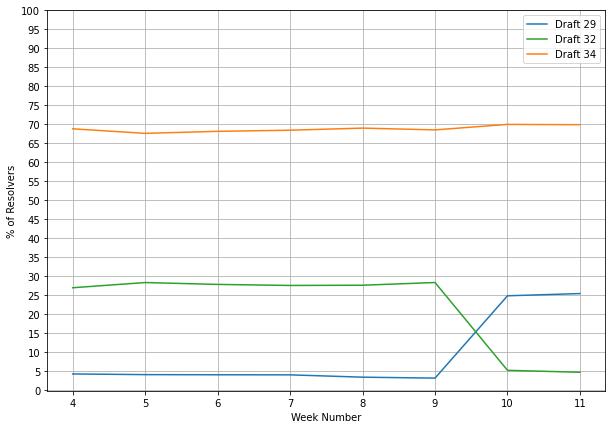

In [16]:
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(1,1,1)

groups = [quic_versions_by_draft[group].tolist() for group in quic_versions_by_draft]

labels = [i for i in range(3, len(quic_versions_by_draft.index) + 3)]

# plt.stackplot(labels, *groups, colors=["tab:blue", "tab:green", "tab:orange"])
plt.plot(labels, quic_versions_by_draft["Draft 29"], color="tab:blue", label="Draft 29")
plt.plot(labels, quic_versions_by_draft["Draft 32"], color="tab:green", label="Draft 32",)
plt.plot(labels, quic_versions_by_draft["Draft 34"], color="tab:orange", label="Draft 34")

plt.xlabel("Week Number")
plt.ylabel("% of Resolvers")
plt.xticks(labels)
ax.set_axisbelow(True)
plt.grid()
plt.yticks(np.arange(0, 105, 5))


plt.legend()
plt.savefig("figures/quic_versions_per_week.pdf", bbox_inches='tight')
plt.show()

## DoQ versions

In [18]:
sqlQuicVersions = """
select 
    strftime('%W', created_at) WeekNumber,
    draft_version, count(*) as count
from q_versions
group by WeekNumber, draft_version;
"""


draft_versions = pd.read_sql_query(sqlQuicVersions, connection)
draft_versions["WeekNumber"] = draft_versions["WeekNumber"].astype("int").sub(26)
draft_versions_per_week_total = draft_versions.groupby(["WeekNumber"])["count"].sum().reset_index(name = "total")
draft_versions = pd.merge(draft_versions, draft_versions_per_week_total, on = "WeekNumber")
draft_versions["percentage"] = (draft_versions["count"] / draft_versions["total"]) * 100

In [19]:
draft_versions_by_draft = draft_versions.pivot(index = "WeekNumber", columns = "draft_version", values = "percentage")

In [20]:
draft_versions_by_draft

draft_version,doq-i00,doq-i02
WeekNumber,,
1,12.174941,87.825059
2,10.955711,89.044289
3,10.392610,89.607390
4,10.103330,89.896670
5,9.283196,90.716804
6,8.352144,91.647856
7,7.760532,92.239468
8,7.278835,92.721165


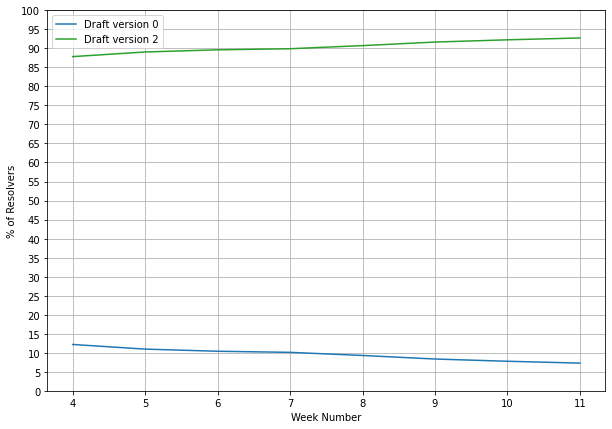

In [21]:
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(1,1,1)

labels = [i for i in range(1, len(draft_versions_by_draft.index) + 1)]

plt.plot(labels, draft_versions_by_draft["doq-i00"], color="tab:blue", label="Draft version 0")
plt.plot(labels, draft_versions_by_draft["doq-i02"], color="tab:green", label="Draft version 2",)

plt.xlabel("Week Number")
plt.ylabel("% of Resolvers")
plt.xticks(labels)
ax.set_axisbelow(True)
plt.grid()
plt.yticks(np.arange(0, 105, 5))


plt.legend()
plt.savefig("figures/draft_versions_per_week.pdf", bbox_inches='tight')
plt.show()

## DoQ versions port

In [271]:
sqlQuicVersions = """
select 
    strftime('%W', created_at) WeekNumber,
    draft_version, port, count(*) as count
from q_versions
group by WeekNumber, draft_version, port;
"""


draft_versions_port = pd.read_sql_query(sqlQuicVersions, connection)
draft_versions_port["WeekNumber"] = draft_versions_port["WeekNumber"].astype("int").sub(26)

In [272]:
draft_versions_port[(draft_versions_port["draft_version"] == "doq-i02") & (draft_versions_port["port"] == 784)]

,WeekNumber,draft_version,port,count
1,1,doq-i02,784,562
4,2,doq-i02,784,558
7,3,doq-i02,784,568
11,4,doq-i02,784,574
15,5,doq-i02,784,567
18,6,doq-i02,784,585
22,7,doq-i02,784,609
26,8,doq-i02,784,602


In [172]:
draft_versions_by_draft = draft_versions.pivot(index = "WeekNumber", columns = "draft_version", values = "count")

## Fluctuation

In [192]:
weeks = fluctuations.getWeeklyServers()

same_as_previous = []
new_from_previous = []

for i in range(1, len(weeks)):
    prev_week = set(weeks[i - 1])
    cur_week = set(weeks[i])
    still_from_previous_week = len(prev_week) - len(prev_week - cur_week)
    new_from_previous_week = len(prev_week - cur_week)
    same_as_previous.append(still_from_previous_week)
    new_from_previous.append(new_from_previous_week)

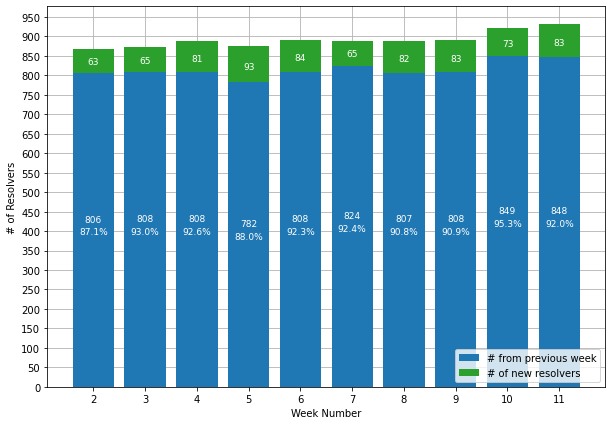

In [230]:
fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(1,1,1)

groups = [same_as_previous, new_from_previous]

labels = [i for i in range(2, len(same_as_previous) + 2)]

# plt.stackplot(labels, *groups, colors=["tab:blue", "tab:green"])
bar1 = ax.bar(labels, same_as_previous, label = "# from previous week", bottom = None, color="tab:blue")
bar2 = ax.bar(labels, new_from_previous, label = "# of new resolvers", bottom = same_as_previous, color="tab:green")

for idx, rect in enumerate(bar1):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 0.52*height,
                same_as_previous[idx],
                ha='center', va='bottom', color = "white", fontsize = 9)
        ax.text(rect.get_x() + rect.get_width()/2., 0.48*height,
                "{:.1%}".format(same_as_previous[idx] / len(weeks[idx - 1])),
                ha='center', va='bottom', color = "white", fontsize = 9)
        
for idx, rect in enumerate(bar2):
        height = rect.get_height()
        y = rect.get_y()
        ax.text(rect.get_x() + rect.get_width()/2., (0.3*height) + y,
                new_from_previous[idx],
                ha='center', va='bottom', color = "white", fontsize = 9)

plt.xlabel("Week Number")
plt.ylabel("# of Resolvers")
plt.xticks(labels)
ax.set_axisbelow(True)
plt.grid()
plt.yticks([i for i in range(0, 1000, 50)])
# plt.ylim([0, 950])
# plt.xlim([0.5, 11.5])


plt.legend(loc = "lower right")
plt.savefig("figures/resolver_fluctuation_week_over_week.pdf", bbox_inches='tight')
plt.show()

## Total Number Found

In [243]:
port784 = fluctuations.getTotalSetForPort()
port8853 = fluctuations.getTotalSetForPort(8853)
port853 = fluctuations.getTotalSetForPort853()

In [244]:
totalSet = set()

for resolver in port784:
    totalSet.add(resolver + "-784")
for resolver in port8853:
    totalSet.add(resolver + "-8853")
for resolver in port853:
    totalSet.add(resolver + "-853")

In [246]:
len(totalSet)

1604

In [250]:
pd.Series(new_from_previous).sum() + 869

1641